**Stock Price Prediction using Machine Learning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Start by importing dataset
df = pd.read_csv('/content/drive/MyDrive/data/Tesla.csv', sep=',')
df.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [ ]:
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Adj Close,0


In [ ]:
splitted = df['Date'].str.split('/', expand=True)

df['day'] = splitted[1].astype('int')
df['month'] = splitted[0].astype('int')
df['year'] = splitted[2].astype('int')

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,day,month,year
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999,29,6,2010
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000,30,6,2010
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999,1,7,2010
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001,2,7,2010
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001,6,7,2010


In [ ]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,day,month,year,is_quarter_end
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999,29,6,2010,1
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000,30,6,2010,1
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999,1,7,2010,0
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001,2,7,2010,0
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001,6,7,2010,0


In [ ]:
# We can drop date as non-relevant column
df.drop('Date', axis=1).groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,Adj Close,day,month,year
is_quarter_end,,,,,,,,,
0,130.813739,133.182620,128.257229,130.797709,4.461581e+06,130.797709,15.686501,6.141208,2013.353464
1,135.679982,137.927032,133.455777,135.673269,3.891084e+06,135.673269,15.657244,7.584806,2013.314488


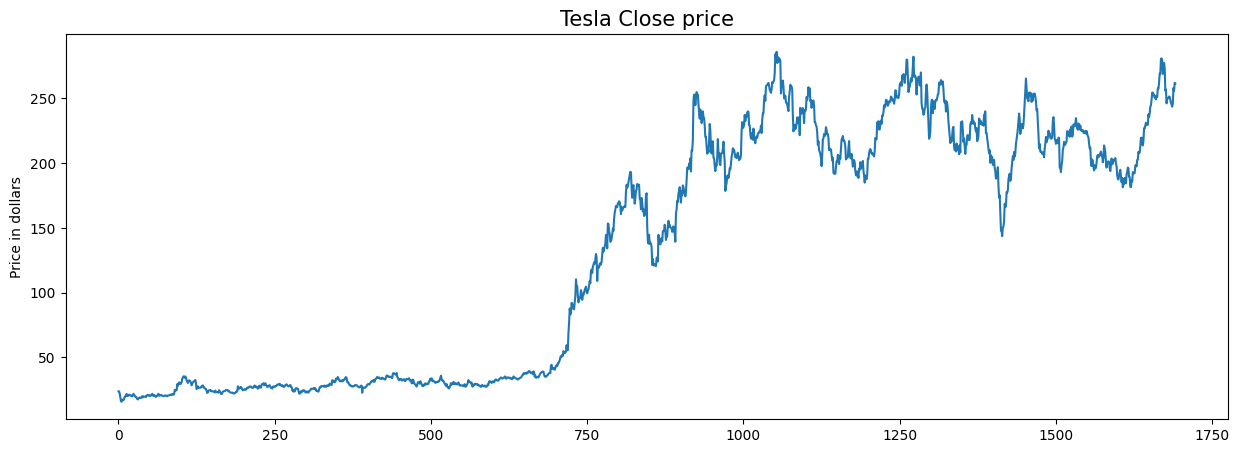

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Tesla Close price', fontsize=15)
plt.ylabel('Price in dollars')
plt.show()

In [ ]:
df[df['Close'] == df['Adj Close']].shape

(1692, 11)

In [ ]:
# We can drop the Adjusted close price as it is the same as the closing price
df.drop('Adj Close', axis=1, inplace=True)

In [ ]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [ ]:
df.sample(10)

,Date,Open,High,Low,Close,Volume,day,month,year,is_quarter_end,open-close,low-high,target
116,12/13/2010,31.639999,31.770000,30.400000,30.549999,410400,13,12,2010,1,1.090000,-1.370000,0
256,7/5/2011,29.020000,29.520000,28.709999,29.139999,996000,5,7,2011,0,-0.119999,-0.810001,0
1142,1/12/2015,203.050003,204.470001,199.250000,202.210007,5950300,12,1,2015,0,0.839996,-5.220001,1
822,10/3/2013,175.050003,179.690002,168.000000,173.309998,23816500,3,10,2013,0,1.740005,-11.690002,1
195,4/6/2011,26.990000,27.010000,25.799999,26.490000,1288300,6,4,2011,0,0.500000,-1.210001,1
481,5/24/2012,31.250000,31.250000,29.690001,30.280001,1075600,24,5,2012,0,0.969999,-1.559999,0
262,7/13/2011,28.430000,29.030001,27.900000,28.639999,1066000,13,7,2011,0,-0.209999,-1.130001,0
1346,11/2/2015,208.919998,215.800003,207.220001,213.789993,3927900,2,11,2015,0,-4.869995,-8.580002,0
1016,7/14/2014,219.990005,228.789993,215.449997,226.699997,7203200,14,7,2014,0,-6.709992,-13.339996,0
1424,2/25/2016,178.649994,188.520004,175.199997,187.429993,5750700,25,2,2016,0,-8.779999,-13.320007,1


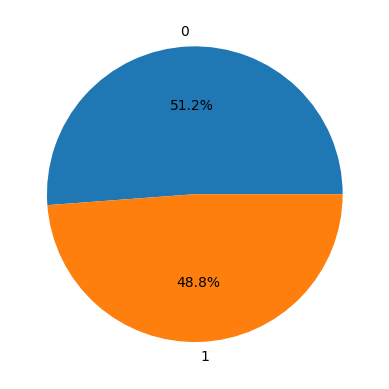

In [ ]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

In [ ]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

In [ ]:
# Apply scaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1353, 3), (339, 3))

In [ ]:
from sklearn.linear_model import LogisticRegression
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{model} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(
    y_train, model.predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(
    y_test, model.predict_proba(X_test)[:,1]))

LogisticRegression() : 
Training Accuracy :  0.5212864161558889
Validation Accuracy :  0.5023673583066426
SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.48001732488089144
Validation Accuracy :  0.526006127280323
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Ac